In [54]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate

load_dotenv()

True

In [55]:
llm = ChatOpenAI (model='gpt-4o-mini')
str_parser = StrOutputParser()

In [56]:
class ReviewSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="Review of the user")

In [57]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [58]:
structured_model = llm.with_structured_output(ReviewSchema)
structured_model2 = llm.with_structured_output(DiagnosisSchema)

In [59]:
prompt = PromptTemplate(
    input_variables=["review"],
    template="Analyze the following review and determine if the sentiment is positive or negative: {review}"
)
Review_prompt = PromptTemplate(
    input_variables=["review", "sentiment"],
    template="Based on this, make a {sentiment} feedback. If the user says something nonsensical, handle it appropriately.\nContext: {review}"
)

In [60]:
# define state
class state(TypedDict):
    review:str
    sentiment: str
    feedback:str
    diagnosis: dict

In [61]:
# Define the graph
graph = StateGraph(state)

In [62]:
def positive_feedback(state: state) -> state:
    chain =  Review_prompt | llm | str_parser
    res = chain.invoke({"review": state["review"], "sentiment" : state["sentiment"]})

    state["feedback"] = res

    return {"feedback": res}

In [63]:
def run_diagnosis(state: state) -> state:

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)
    

    return {"diagnosis": response.model_dump()}

In [64]:
def negative_feedback(state: state) -> state:
    diagnosis = state["diagnosis"]

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    res = llm.invoke(prompt).content

    return {"feedback": res}

In [65]:
def sentiment(state: state) -> state:
    chain = prompt | structured_model
    res = chain.invoke({"review": state["review"]})
    
    return {"sentiment": res.sentiment}

In [66]:
def check_connection(
    state: state,
) -> Literal["positive_feedback", "run_diagnosis"]:
    sentiment = state["sentiment"]
    if sentiment == "positive":
        return "positive_feedback"
    elif sentiment == "negative":
        return "run_diagnosis"

In [67]:
# add nodes
graph.add_node("sentiment", sentiment)

# conditional nodes
graph.add_node("positive_feedback", positive_feedback)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_feedback", negative_feedback)

In [68]:
# add edges
graph.add_edge(START, "sentiment")
# condiational edges
graph.add_conditional_edges("sentiment", check_connection)
graph.add_edge("positive_feedback", END)
graph.add_edge("run_diagnosis", "negative_feedback")
graph.add_edge("negative_feedback", END)

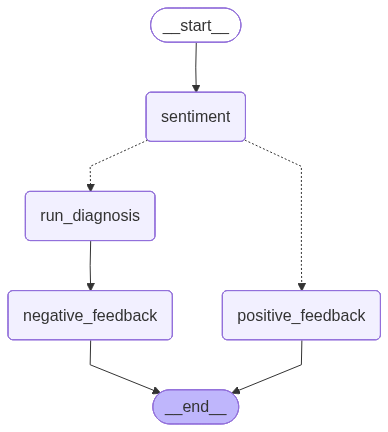

In [69]:
# compile the graph
work_flow = graph.compile()
work_flow


In [70]:
# execute the graph

initial_state = {"review": "phone screen , sound disply green line in samsung"}

final_state = work_flow.invoke(initial_state)

In [71]:
# print state
final_state 
print(final_state)


{'review': 'phone screen , sound disply green line in samsung', 'sentiment': 'negative', 'feedback': "Subject: We're Here to Help with Your Bug Issue\n\nHi [User's Name],\n\nI hope this message finds you well. I want to express my sincere apologies for the frustration you've experienced due to the bug issue. I understand how critical this is for you, and I appreciate your patience as we work together to resolve it.\n\nTo get started, could you please provide me with more details about the issue you're facing? Specifics such as any error messages you’ve encountered, the steps leading up to the problem, or any recent changes made will be incredibly helpful in diagnosing the issue quickly.\n\nRest assured, we are committed to addressing this with the urgency it deserves and will do everything we can to get it resolved as soon as possible. Your experience is important to us, and we’re here to support you.\n\nThank you for your understanding. I look forward to your response so we can get th